<a href="https://colab.research.google.com/github/replyeshab/text-classification/blob/main/text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
df = pd.read_csv('wine-reviews.csv',usecols = ['country','description','points','price','variety','winery'])

In [ ]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [ ]:
df = df.dropna(subset =["description","points"])

Text(0.5, 1.0, 'Points Histogram')

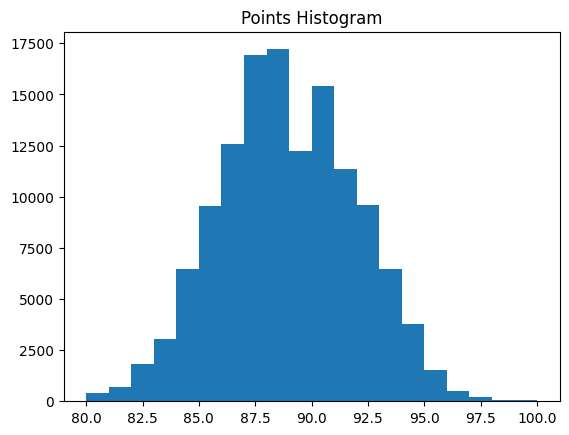

In [ ]:
plt.hist(df.points,bins = 20)
plt.title("Points Histogram")

In [ ]:
df["label"] = (df.points>=90).astype(int)
df = df[["description","label"]]

In [ ]:
train,val,test = np.split(df.sample(frac = 1),[int(0.8*len(df)),int(0.9*len(df))])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In essence, this function below transforms a DataFrame containing text descriptions and labels into an optimized TensorFlow Dataset, ready for use in model training. The dataset is batched, shuffled (if specified), and prefetched for efficient processing during training.

In [ ]:
def df_to_dataset(dataframe,shuffle=True,batch_size = 1024):
    df = dataframe.copy()
    labels = df.pop('label')
    df = df["description"]
    ds = tf.data.Dataset.from_tensor_slices((df,labels))
    if shuffle:
        ds = ds.shuffle(buffer_size = len(dataframe))
    ds= ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [ ]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)

In essence, this code snippet imports a pre-trained word embedding model from TensorFlow Hub and creates a Keras layer that can be used to embed text data into a 50-dimensional vector space. The layer is set to be trainable, enabling the embeddings to be fine-tuned for your specific task

In [ ]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.28201708, -0.27620697,  0.06734273, ...,  0.0065331 ,
        -0.21352239,  0.00469734],
       [ 0.3800376 , -0.20539519, -0.0048373 , ...,  0.06476596,
        -0.31872088,  0.07661499],
       [ 0.5197894 , -0.5004347 , -0.09407692, ...,  0.05444228,
         0.15726365, -0.01801762],
       ...,
       [ 0.22522594, -0.14297102,  0.00739028, ...,  0.09734144,
        -0.2270447 ,  0.02376563],
       [ 0.49802154, -0.09922393, -0.10374336, ...,  0.09061489,
        -0.3080603 , -0.02149455],
       [ 0.3213781 , -0.31905004,  0.07895303, ...,  0.09597398,
        -0.07975299,  0.15191019]], dtype=float32)>

In Keras, a Lambda layer is a way to create a custom layer that performs an arbitrary function on its input. It's essentially a wrapper that allows you to insert any Python function into your model as a layer. This function can be a simple operation like squaring the input, or a more complex one involving multiple steps.

Here's a breakdown of how it works:

Purpose: Lambda layers provide flexibility to incorporate operations not readily available as built-in Keras layers. They are particularly useful for simple, stateless operations or quick experimentation.
How it works: You define a function that takes the input tensor as an argument and returns the modified tensor. This function is then passed to the tf.keras.layers.Lambda constructor to create the layer.
Usage: When the layer is called during model execution, the defined function is applied to the input tensor, and the result is passed to the next layer.

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Lambda(lambda x: hub_layer(x)))  # Wrap hub_layer in a Lambda layer
model.add(tf.keras.layers.Reshape((50,))) # Reshape to (batch_size, embedding_dimension)
model.add(tf.keras.layers.Dense(16,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [ ]:
model.evaluate(train_data)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3925 - loss: 0.7083


[0.7081791758537292, 0.3930041491985321]

In [ ]:
model.evaluate(valid_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7110 - loss: 0.5700


[0.570300281047821, 0.7091636657714844]

In [ ]:
history = model.fit(train_data,epochs = 10,validation_data = valid_data)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5576 - loss: 0.6843 - val_accuracy: 0.6247 - val_loss: 0.6439
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6243 - loss: 0.6500 - val_accuracy: 0.6248 - val_loss: 0.6218
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6333 - loss: 0.6323 - val_accuracy: 0.6747 - val_loss: 0.6023
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6534 - loss: 0.6190 - val_accuracy: 0.6962 - val_loss: 0.5902
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6657 - loss: 0.6081 - val_accuracy: 0.6959 - val_loss: 0.5842
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6741 - loss: 0.6036 - val_accuracy: 0.6985 - val_loss: 0.5803
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6800 - loss: 0.5961 - val_accuracy: 0.7034 - val_loss: 0.5751
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6822 - loss: 0.5956 - val_accu

In [ ]:
model.evaluate(test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7054 - loss: 0.5749


[0.5723908543586731, 0.7091090679168701]

# LSTM


LSTMs are a special kind of recurrent neural network (RNN) designed to address the vanishing gradient problem that often arises when training traditional RNNs on long sequences. They are particularly well-suited for tasks involving sequential data, such as natural language processing, speech recognition, and time series analysis.

Here's a breakdown of their key features and how they work:

Motivation:

Traditional RNNs struggle to learn long-range dependencies in sequences because the gradients (used to update the network's weights during training) tend to diminish as they propagate back through time. This is known as the vanishing gradient problem.
LSTMs were designed to overcome this limitation by introducing a memory mechanism that allows them to retain information for longer periods.
Key Components:

Cell State: This is the core of an LSTM unit. It acts as a conveyor belt carrying information through time. It allows the network to remember or forget information selectively.
Gates: LSTMs use three types of gates to control the flow of information into and out of the cell state:
Forget Gate: Decides what information to discard from the cell state.
Input Gate: Determines what new information to store in the cell state.
Output Gate: Selects what information from the cell state to output.
Working Principle:

At each time step, the LSTM receives an input and the previous hidden state.
The forget gate decides what information to discard from the previous cell state.
The input gate determines what new information to add to the cell state.
The cell state is updated based on the outputs of the forget and input gates.
The output gate decides what information from the cell state to output as the current hidden state.

In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens = 2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(32,activation = "relu"),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1,activation = "sigmoid")
                             ])

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [ ]:
model.evaluate(train_data)
model.evaluate(valid_data)

102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - accuracy: 0.5849 - loss: 0.6926
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - accuracy: 0.5840 - loss: 0.6927


In [ ]:
history = model.fit(train_data,epochs = 5,validation_data = valid_data)

Epoch 1/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 57s 481ms/step - accuracy: 0.6552 - loss: 0.6246 - val_accuracy: 0.8210 - val_loss: 0.3872
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 49s 470ms/step - accuracy: 0.8345 - loss: 0.3696 - val_accuracy: 0.8401 - val_loss: 0.3546
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 74s 400ms/step - accuracy: 0.8468 - loss: 0.3448 - val_accuracy: 0.8377 - val_loss: 0.3538
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 42s 415ms/step - accuracy: 0.8495 - loss: 0.3408 - val_accuracy: 0.8423 - val_loss: 0.3481
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 40s 395ms/step - accuracy: 0.8507 - loss: 0.3315 - val_accuracy: 0.8410 - val_loss: 0.3518


In [ ]:
model.evaluate(test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - accuracy: 0.8415 - loss: 0.3473


[0.34698134660720825, 0.8424373269081116]